In [71]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls
from src.network_sim import NetworkSimulator
from src.algorithm import weighted_minimum_mean_square_error
from src.sc import SyntheticControl

%reload_ext autoreload
%autoreload 2
%aimport src

In [2]:
frequency_Hz= 50 * 1e9 # Hz
distance_m = 50
sample_size = 10

In [3]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-112.772957,-98.548980
1,-118.301760,-109.886204
2,-132.653355,-106.489039
3,-121.169680,-102.471876
4,-135.580905,-94.089869
5,-116.983048,-93.675827
6,-121.841991,-102.468280
7,-139.698003,-120.477607
8,-136.520968,-107.222331
9,-99.984742,-116.563339


In [149]:
simulator = NetworkSimulator(Tx_radius=100, Rx_radius=25, num_Tx_known=3, num_Rx_per_Tx_known=5, num_Tx_unknown=2, num_Rx_per_Tx_unknown=3)

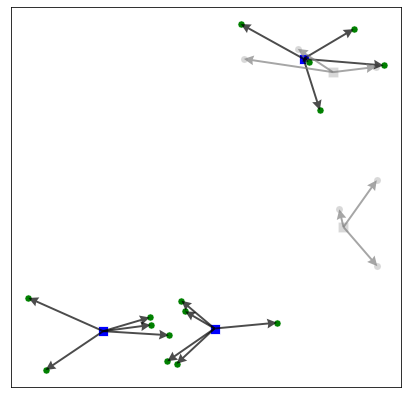

In [150]:
simulator.plot_network()

In [151]:
pd.DataFrame(simulator.gain_mat_dBm)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-103.863133,-92.791364,-99.343280,-93.545275,-75.332640,-131.972010,-125.711019,-120.740906,-119.029620,-128.668743,...,-144.073747,-130.795843,-124.081061,-123.446567,-115.540755,-116.152414,-104.740089,-78.202034,-90.816763,-86.202553
1,-108.216925,-131.984670,-134.487939,-126.841600,-122.307716,-99.421814,-87.853537,-99.068763,-94.570876,-94.941991,...,-111.220274,-97.062124,-103.842096,-85.736070,-111.623714,-107.316205,-116.194303,-132.649945,-118.706421,-118.470364
2,-122.703850,-129.113026,-145.216946,-126.410670,-131.695762,-92.428656,-90.447219,-120.934299,-119.217384,-98.993944,...,-98.709816,-90.969826,-100.344066,-87.256899,-127.779074,-119.139941,-120.578899,-127.564643,-137.029651,-117.974778
3,-113.764392,-121.183023,-104.533302,-119.702029,-118.195688,-117.118959,-108.634758,-111.265756,-97.423413,-101.378929,...,-130.436594,-117.765768,-111.829683,-117.179975,-104.332120,-97.090044,-87.180253,-105.055670,-113.060675,-116.903087
4,-89.140533,-103.839461,-99.577892,-97.122210,-84.211831,-112.867891,-135.842937,-119.169275,-121.146332,-113.952903,...,-134.444065,-128.055104,-129.118929,-128.899234,-121.244946,-120.817394,-111.351619,-88.609064,-103.080243,-97.205151


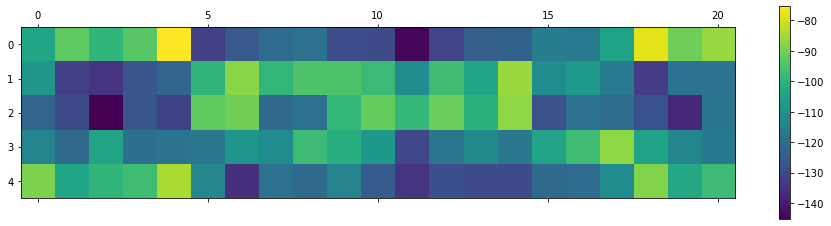

In [152]:
simulator.plot_gain_mat()

In [153]:
simulator.weighted_sum_rate_Gnats(Rx_powers_mW=[250 for i in range(len(simulator.x_Rx))], Rx_weights=np.ones(len(simulator.x_Rx)))

66.83090746276778

In [154]:
part = 'known'
gain_mat_mW = simulator.get_gain_mat(part=part, unit='mW')

if part == 'unknown':
    Tx_idx_shift = len(simulator.x_Tx) - gain_mat_mW.shape[0]
    Rx_idx_shift = len(simulator.x_Rx) - gain_mat_mW.shape[1]
else:
    Tx_idx_shift = 0
    Rx_idx_shift = 0


powers_list = weighted_minimum_mean_square_error(
    simulator = simulator, 
    gain_mat_mW = gain_mat_mW,
    Rx_powers_mW = [250 for i in range(len(simulator.x_Rx))],
    Rx_max_powers_mW = [500 for i in range(gain_mat_mW.shape[1])],
    Rx_weights=np.ones(len(simulator.x_Rx)),
    Tx_idx_shift=Tx_idx_shift,
    Rx_idx_shift=Rx_idx_shift,
)

[0.0, 0.0, 0.0, 0.0, 105.92493169564823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 363.29520754787836, 0.0, 0.0, 0.0, 250, 250, 250, 250, 250, 250]
Weighted Sum Rate: 90.70548067835638
Round 5000 0.0011934044052254197
	 Power: [0.0, 0.0, 0.0, 0.0, 105.92493169564823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 363.29520754787836, 0.0, 0.0, 0.0, 250, 250, 250, 250, 250, 250]


In [178]:
interferences_list = []
for p in [np.random.uniform(0,500, len(simulator.x_Rx)) for i in range(5000)]:
    observed_interference = simulator.Rx_interference(p)[Rx_idx_shift: Rx_idx_shift+gain_mat_mW.shape[1]]
    interferences_list.append(observed_interference)

TypeError: can't multiply sequence by non-int of type 'float'

In [156]:
sc = []
for i in range(gain_mat_mW.shape[1]):
    sc_i = SyntheticControl().fit(X=pd.DataFrame(interferences_list).drop(i, axis=1), y = pd.DataFrame(interferences_list)[i])
    sc.append(sc_i)

In [165]:
check_Rx = 2
p = [200 for i in range(len(simulator.x_Rx))]
observed_interferences = simulator.Rx_interference(p)[Rx_idx_shift: Rx_idx_shift+gain_mat_mW.shape[1]]
print('Real Interferences:', observed_interferences[check_Rx])
print('SC Interference', sc[check_Rx].predict(pd.DataFrame(observed_interferences).drop(check_Rx, axis=0)[0]))

Real Interferences: 8.728921480223268e-08
SC Interference 5.752654888188169e-07


In [173]:
sc[0].coef_

array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857])